> **REFERENCES**:
> https://www.kaggle.com/shivamsarawagi/wildimagedetection-0-875
> https://www.kaggle.com/gowrishankarin/eda-with-plotly-smart-cute-and-pretty-people
> https://www.kaggle.com/vaishvik25/blend-of-smiles

# Motivation:
**AAIC team**

# Note:
**As AAIC always do I am doing everything in train data**\
**This run on kaggle kernal, but bargraph was not visible in colab so I took screenshot and merged.**
# Private leader rank 55
**after competition end under 20**

**Reading the directory**

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train_relationships.csv', 'train', 'sample_submission.csv']


**Extracting pretrained vggFaces**
https://github.com/rcmalli/keras-vggface

In [0]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-jah0ms4_
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-jah0ms4_
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=d9bb48bd0e209f8070aa9d5a6b8cd8da7d2c909f1a669050ba332241dcfb21b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-0_1ygax3/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


**Importing all the necessary libraries**

In [0]:
from collections import defaultdict
from glob import glob
from random import choice, sample

import cv2
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D
from keras.models import Model
from keras.preprocessing import image
from keras.optimizers import Adam
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
import h5py


> https://www.kaggle.com/gowrishankarin/eda-with-plotly-smart-cute-and-pretty-people
**HOld tight we are going to see some basic but important visualization**

![](http://)> *https://plot.ly/python/*
* *Plotly's Python graphing library makes interactive, publication-quality graphs. Examples of how to make line plots, scatter plots, area charts, bar charts, error bars, box plots, histograms, heatmaps, subplots, multiple-axes, polar charts, and bubble charts.*

In [0]:
import matplotlib.pyplot as plt
from PIL import Image

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999
pd.options.display.float_format = '{:20, .2f}'.format

> **LOADING the file from directory**

In [0]:
train_df = pd.read_csv("../input/train_relationships.csv")
train_df.head()

p1          p2
0  F0002/MID1  F0002/MID3
1  F0002/MID2  F0002/MID3
2  F0005/MID1  F0005/MID2
3  F0005/MID3  F0005/MID2
4  F0009/MID1  F0009/MID4

In [0]:
train_df.shape

(3598, 2)

In [0]:
files = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser("../input/train")) for f in fn]
files[0]

'../input/train/F0897/MID2/P09464_face1.jpg'

**Creating a dataframe for further working**

**Below dataframe contains the the following column:**
* files-> It contains all the train images from where we can directly load the train images\
* familyID->It contains the familyID(3rd place from right in files)
* kinID-> It contains the kinID(4th place from right in files)
* iniqueID->It contains uniqueID(on concanating familyID with kinID)

In [0]:
train_images = pd.DataFrame({
    'files': files,
    'familyId': [file.split('/')[3] for file in files],
    'kinId': [file.split('/')[4] for file in files],
    'uniqueId': [file.split('/')[3] + '/' + file.split('/')[4] for file in files]
})
train_images.head()

files familyId kinId    uniqueId
0  ../input/train/F0897/MID2/P09464_face1.jpg    F0897  MID2  F0897/MID2
1  ../input/train/F0897/MID5/P09469_face1.jpg    F0897  MID5  F0897/MID5
2  ../input/train/F0897/MID3/P09464_face2.jpg    F0897  MID3  F0897/MID3
3  ../input/train/F0897/MID4/P09471_face1.jpg    F0897  MID4  F0897/MID4
4  ../input/train/F0897/MID4/P09464_face3.jpg    F0897  MID4  F0897/MID4

* From below we can see that there are 470 families in total which comprises of 2316 total uniqueid with kins.

In [0]:
#[.nunique() gives the total unique values].
print("Total number of members in the dataset: {0}".format(train_images["uniqueId"].nunique()))
print("Total number of families in the dataset: {0}".format(train_images["familyId"].nunique()))

Total number of members in the dataset: 2316
Total number of families in the dataset: 470


* from below we can see that
1. FamilyID="F0601" has maximum number of images i.e 776
2. person with uniqueID=F0601/MID6 has maximum number of images

In [0]:
#This section of code counts the maximum value.
family_with_most_pic = train_images["familyId"].value_counts()
kin_with_most_pic = train_images["uniqueId"].value_counts()
print("Family with maximum number of images: {0}, Image Count: {1}".format(family_with_most_pic.index[0], family_with_most_pic[0]))
print("Member with maximum number of images: {0}, Image Count: {1}".format(kin_with_most_pic.index[0], kin_with_most_pic[0]))

Family with maximum number of images: F0601, Image Count: 776
Member with maximum number of images: F0601/MID6, Image Count: 95


* out of various family we are calculating here top family with most pics
> REsult we found out that out of top families the highest pic that contains covers 30%, which can create bias

*https://plot.ly/python/ipython-notebook-tutorial/

In [0]:
#taking 25 families from list
family_series = family_with_most_pic[:25]
labels = (np.array(family_series.index))
sizes = (np.array((family_series / family_with_most_pic.sum()) * 100))#calculating the percentage size

#calculating pipot from plotly
trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title='Pic Count by Families')
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Families')

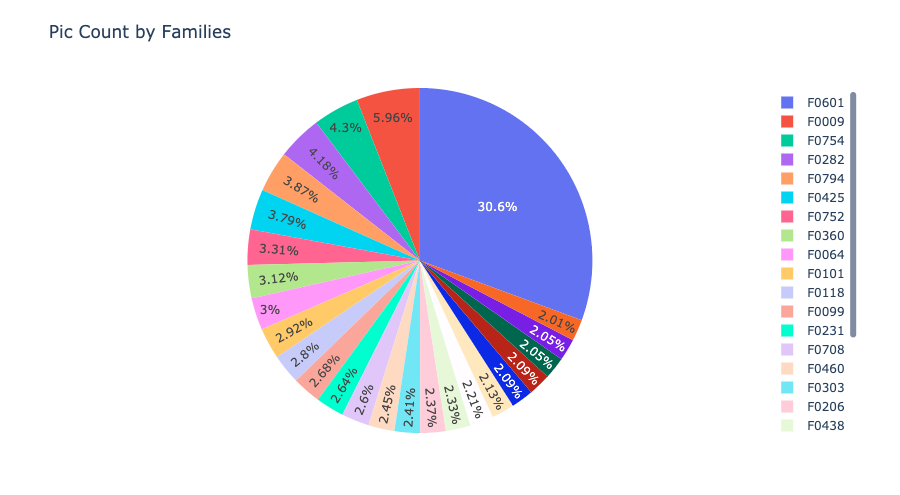

In [0]:
#https://stackoverflow.com/questions/10628262/inserting-image-into-ipython-notebook-markdown
from IPython.display import Image
Image(filename="/content/Screen Shot 2019-08-11 at 2.36.52 PM.png")

> Below we can see the person with most pics.* 

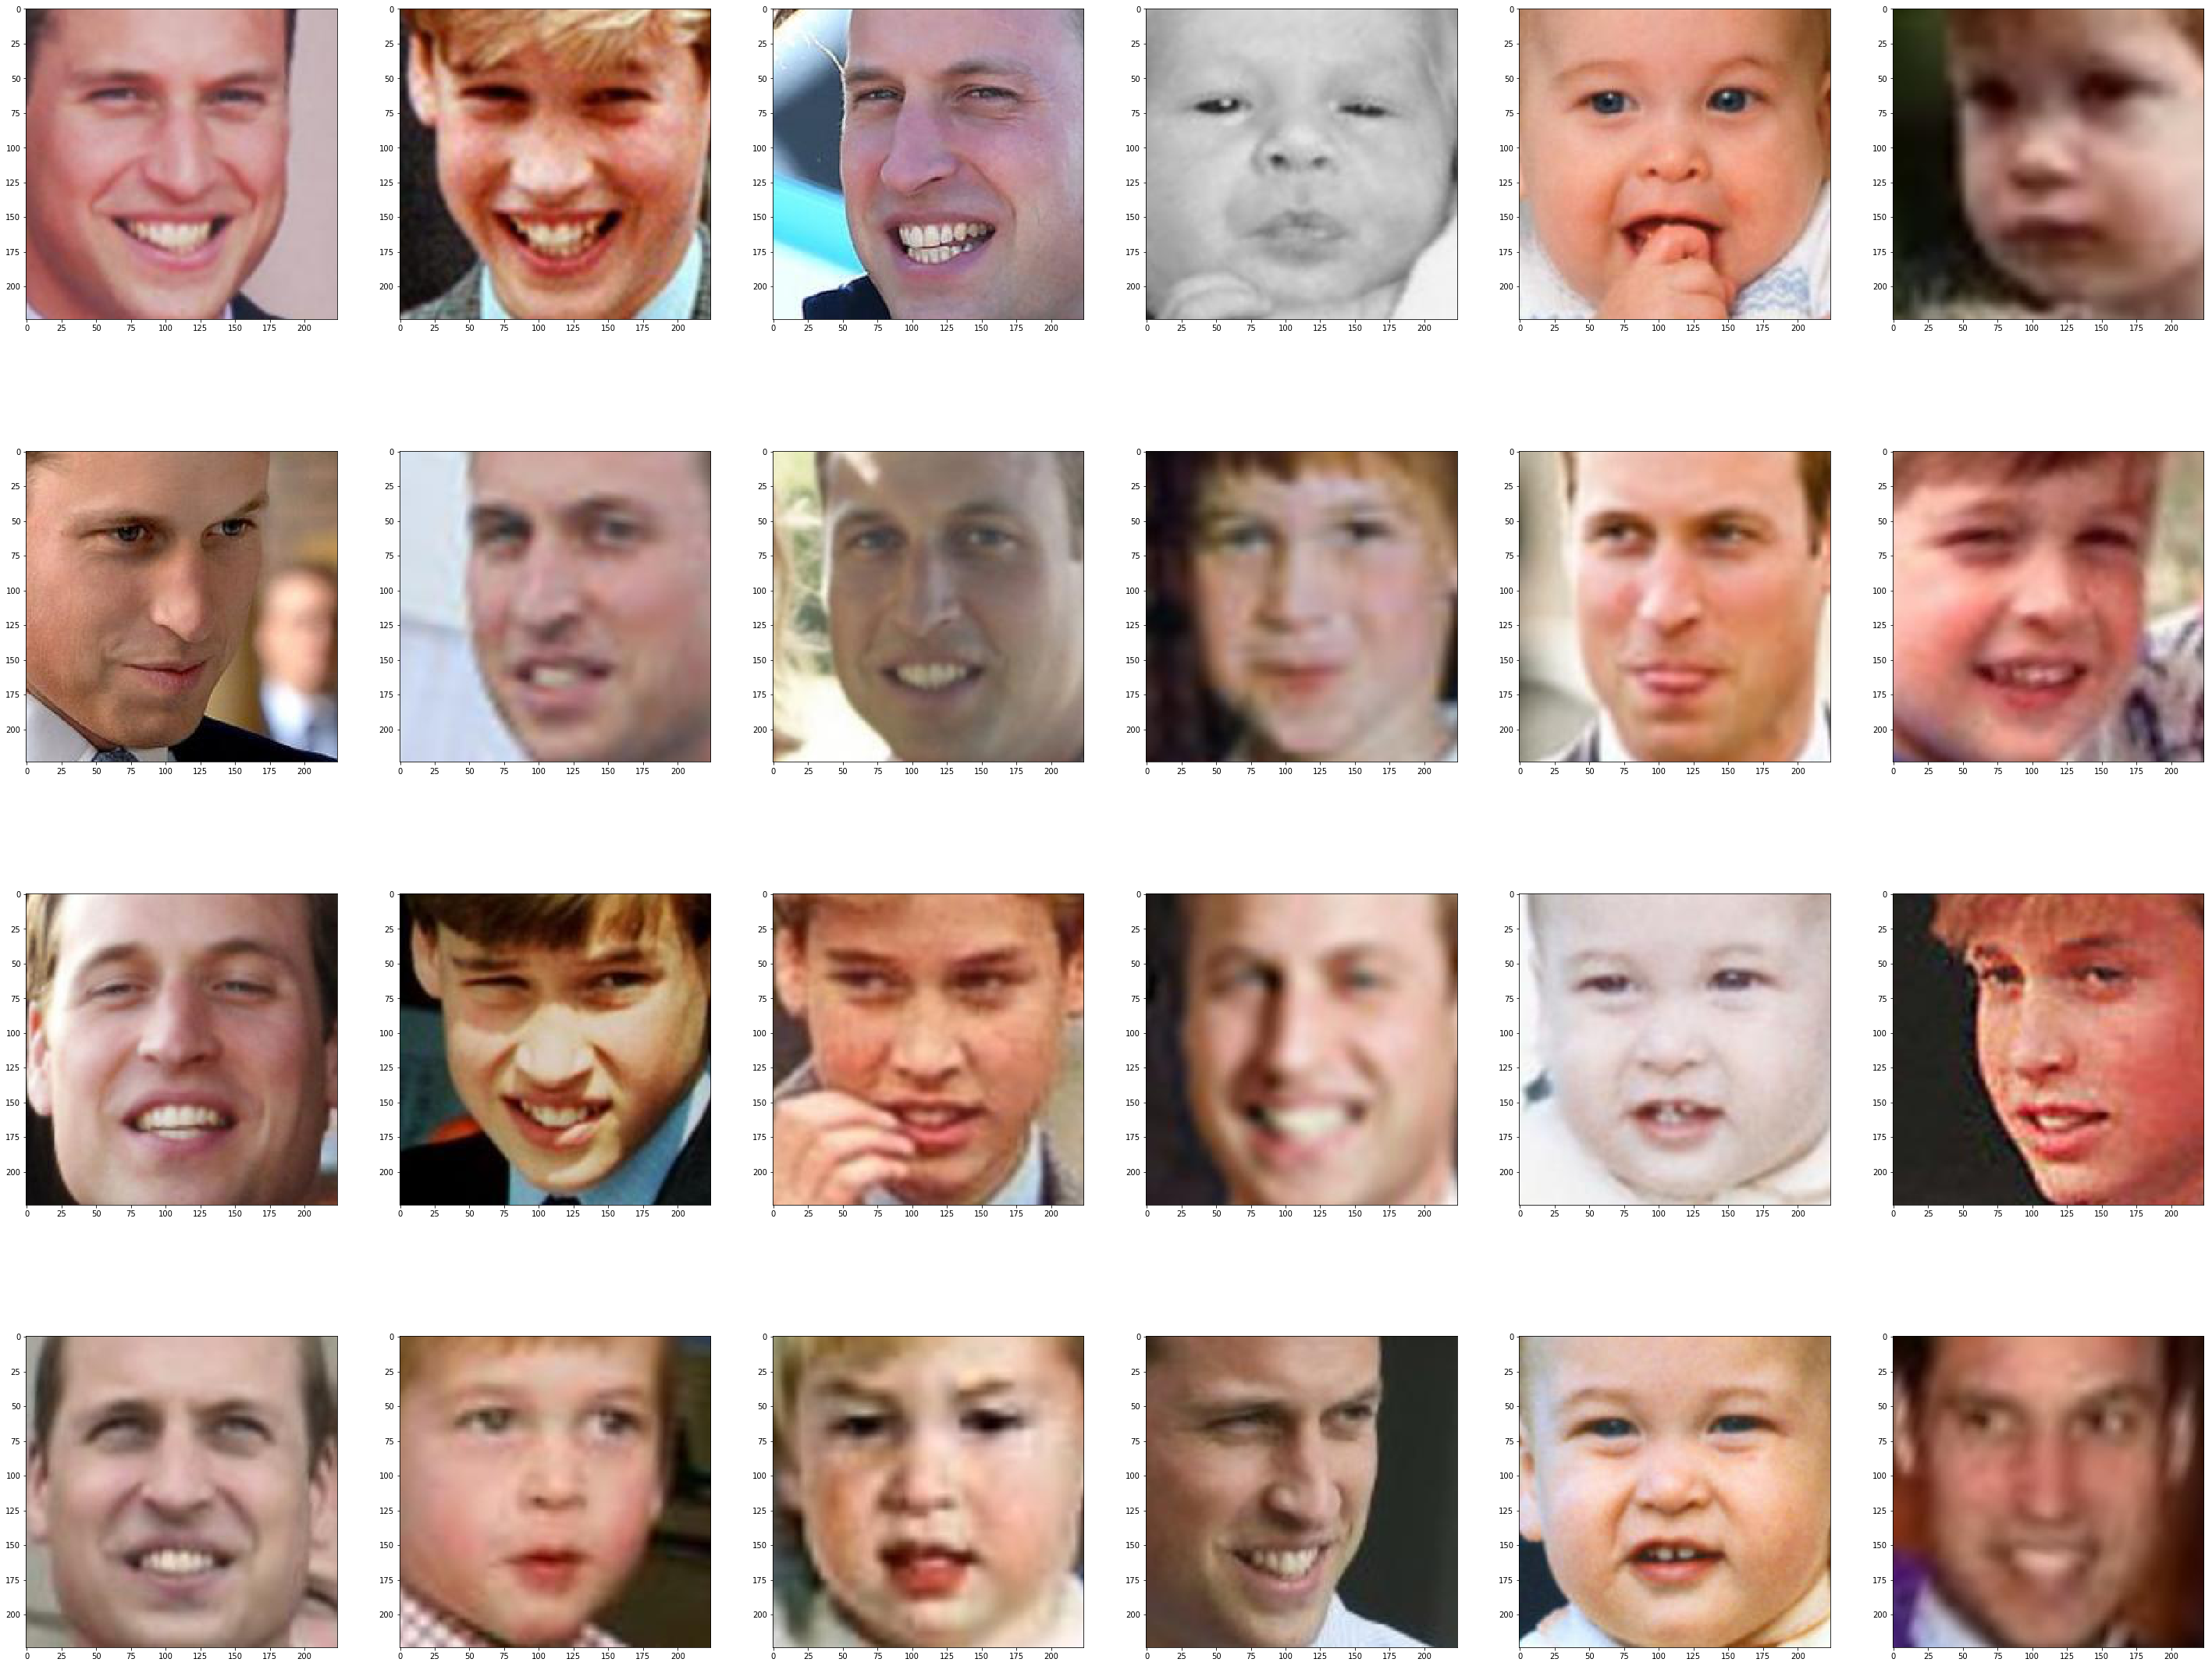

In [0]:
#here we are matching pics with most unique id
most_pic_members = train_images[train_images["uniqueId"] == kin_with_most_pic.index[0]].files.values
fig, ax = plt.subplots(4, 6, figsize=(50, 40))
row = 0
col = 0
for index in range(len(most_pic_members[:24])):
    with open(most_pic_members[index], 'rb') as f:
        #https://pillow.readthedocs.io/en/4.0.x/reference/open_files.html
        #this block of code opens the image and shows it
        img = Image.open(f)
        ax[row][col].imshow(img)
        #for changing the rows and columns of image
        if(col < 5):
            col = col + 1
        else: 
            col = 0
            row = row + 1
fig.show()

> Checking families with maximum number of members and with least number of members.
> and we found out that maxm number of members in a family is 41. and minimum is 1.

In [0]:
#below codes arranges families with their unique id
family_with_most_members = train_images.groupby("familyId")["kinId"].nunique().sort_values(ascending=False)
print("Family with maximum number of members: {0}, Member Count: {1}".format(family_with_most_members.index[0], family_with_most_members[0]))
print("Family with least number of members: {0}, Member Count: {1}".format(
    family_with_most_members.index[len(family_with_most_members)-1], 
    family_with_most_members[len(family_with_most_members)-1]))


Family with maximum number of members: F0601, Member Count: 41
Family with least number of members: F0275, Member Count: 1


**IN this section we are visualizing family with most members.**

In [0]:
#loading family with maximum members.
large_family_df = train_images[train_images["familyId"]  == family_with_most_members.index[0]]
large_family_df.head()

files familyId kinId    uniqueId
1199  ../input/train/F0601/MID2/P11888_face1.jpg    F0601  MID2  F0601/MID2
1200  ../input/train/F0601/MID2/P06281_face1.jpg    F0601  MID2  F0601/MID2
1201  ../input/train/F0601/MID2/P06273_face1.jpg    F0601  MID2  F0601/MID2
1202  ../input/train/F0601/MID2/P12068_face5.jpg    F0601  MID2  F0601/MID2
1203  ../input/train/F0601/MID2/P11906_face4.jpg    F0601  MID2  F0601/MID2

**Pic Count of every member of largest family**

In [0]:
#visualizing the number count by barplot
def render_bar_chart(data_df, column_name, title, filename):
    series = data_df[column_name].value_counts()
    count = series.shape[0]
    #https://plot.ly/python/ipython-notebook-tutorial/
    trace = go.Bar(x = series.index, y=series.values, marker=dict(
        color=series.values,
        showscale=True
    ))
    layout = go.Layout(title=title)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename=filename)

render_bar_chart(large_family_df, 'uniqueId', 'Pic Count by Members', 'members')

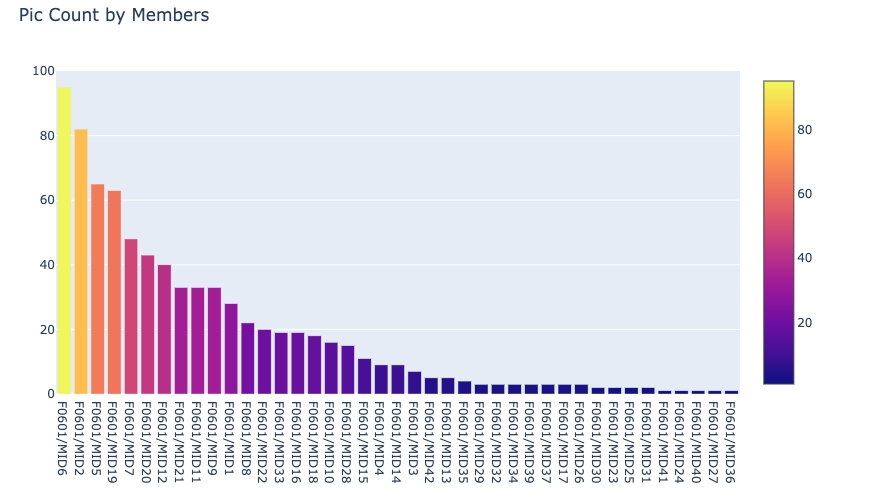

In [0]:
#https://stackoverflow.com/questions/10628262/inserting-image-into-ipython-notebook-markdown
from IPython.display import Image
Image(filename="/content/Screen Shot 2019-08-11 at 2.06.19 PM.png")

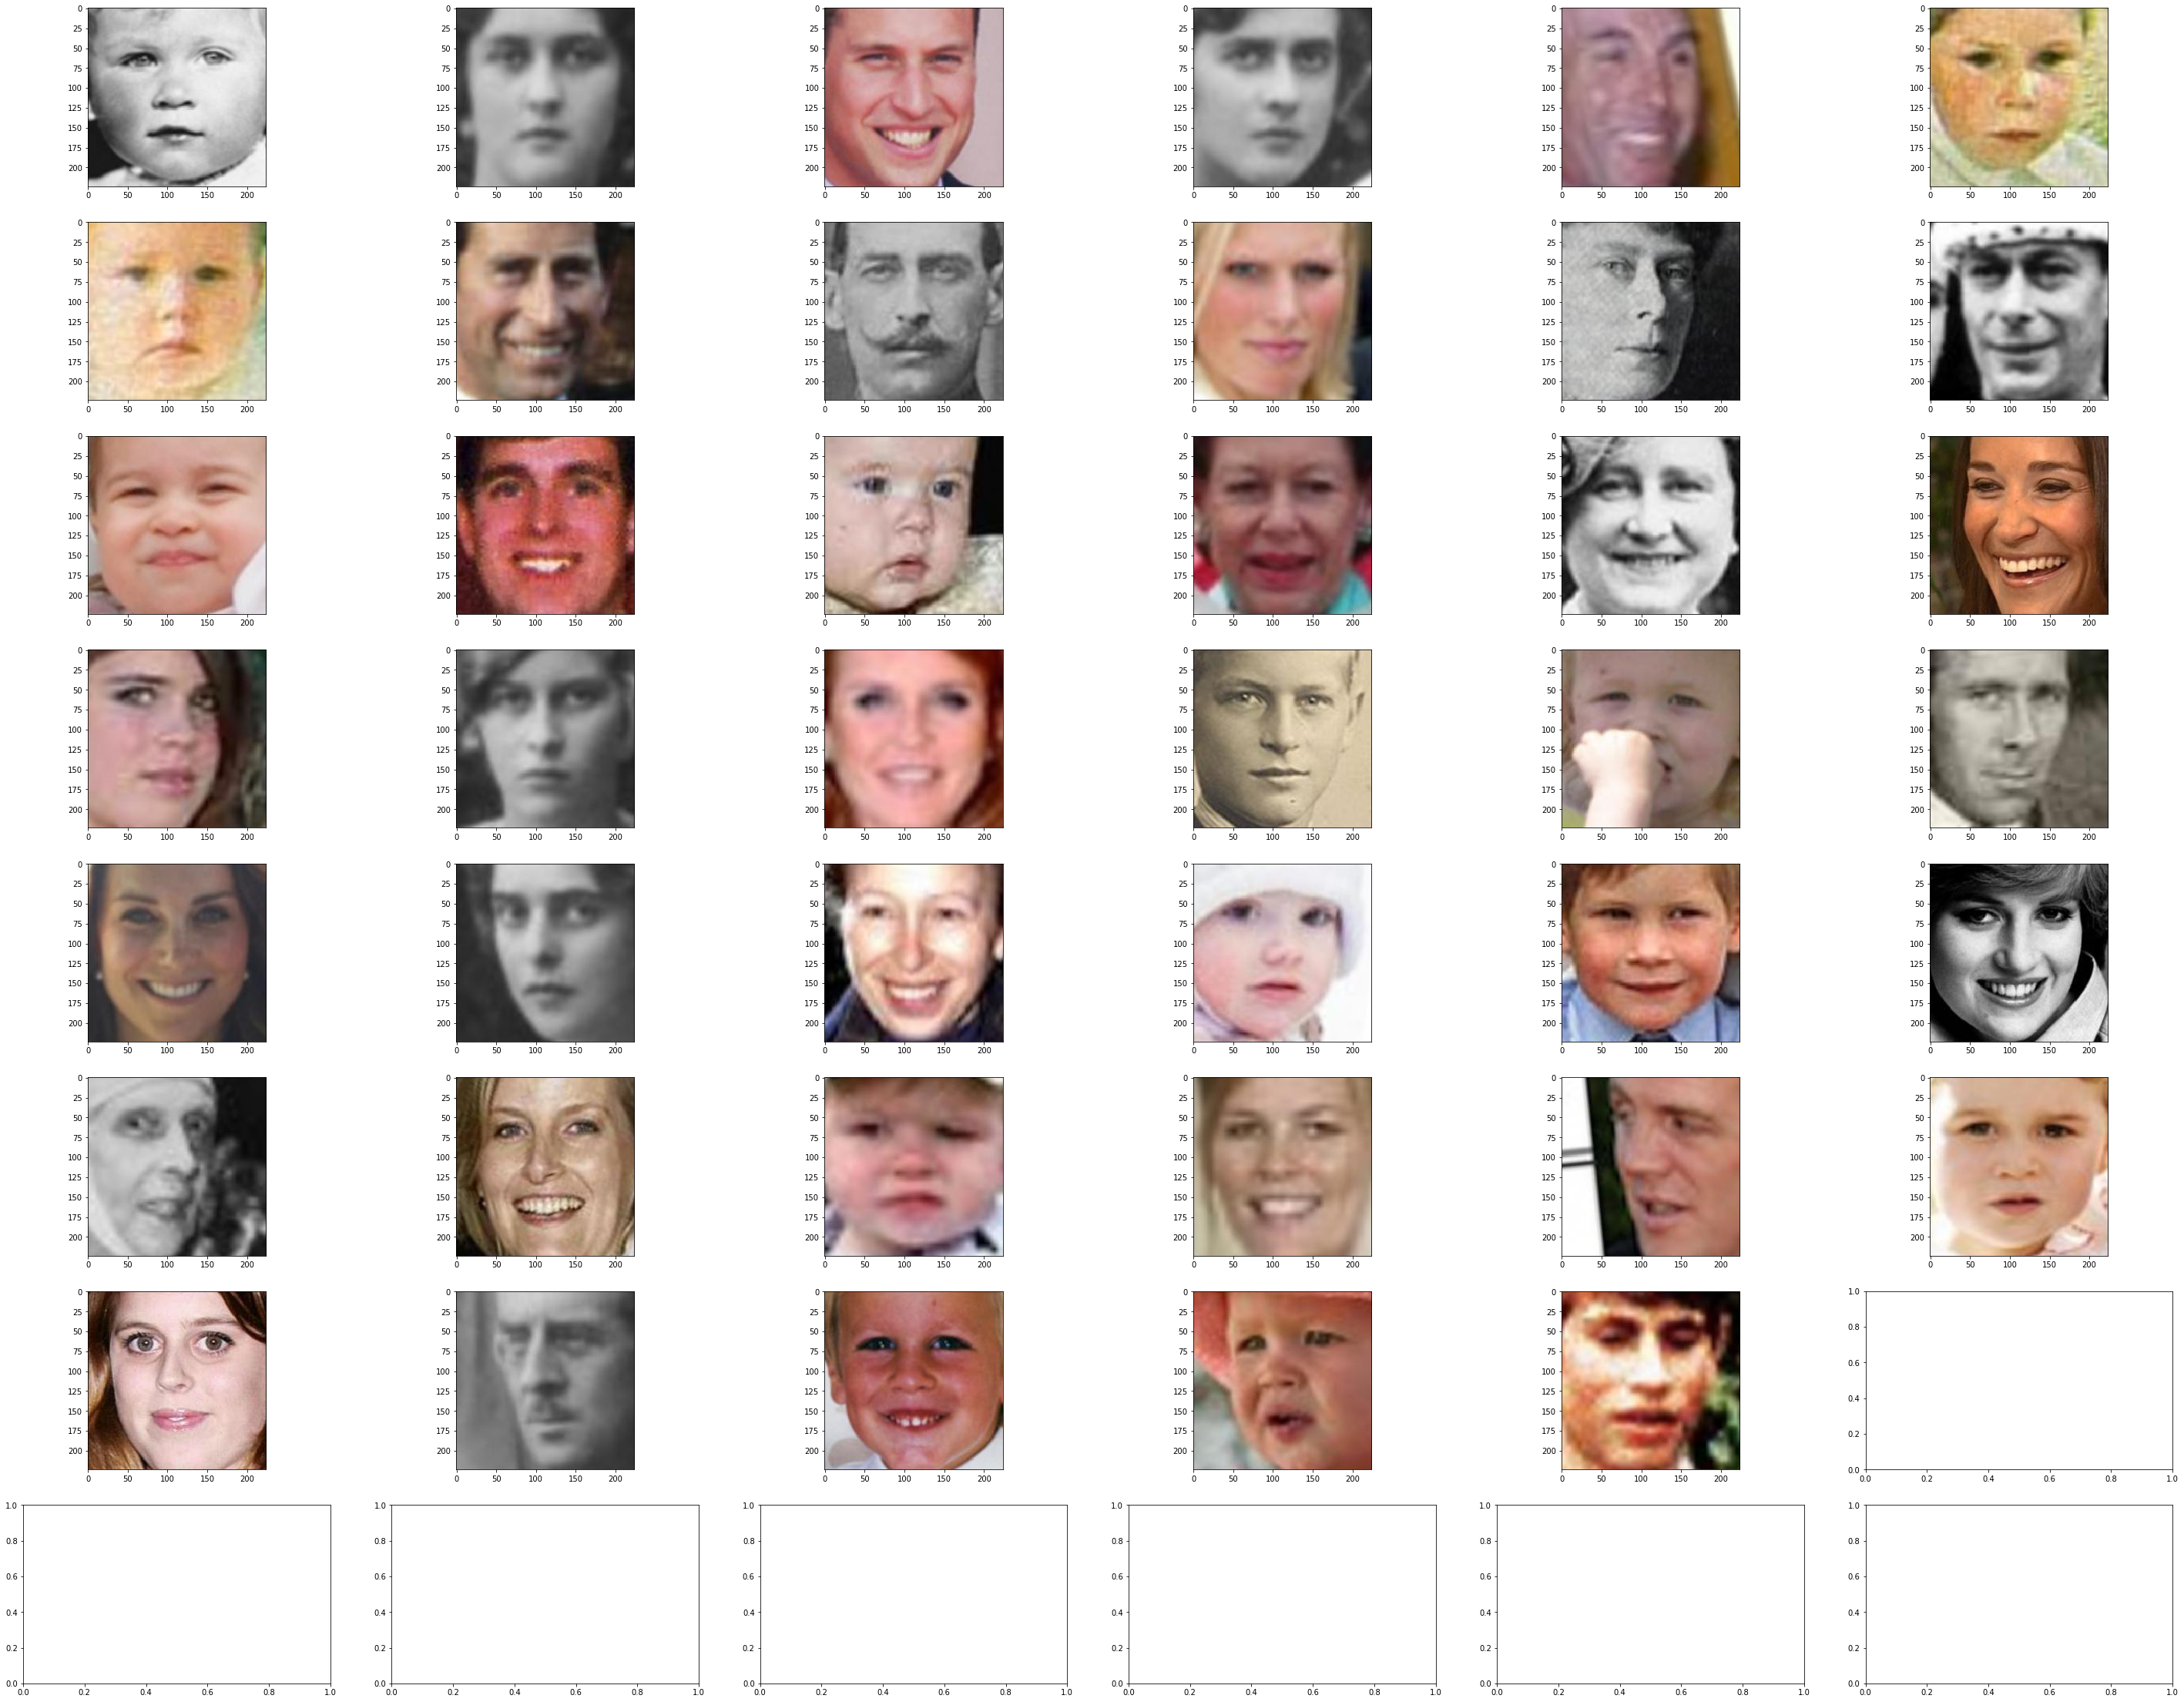

In [0]:
#image of largest family members
def render_images(large_family_df):
    large_family_pics = [large_family_df.loc[large_family_df.loc[large_family_df["uniqueId"] == aKin].index[0]]["files"] for aKin in large_family_df["uniqueId"].unique()]
    nrows = round(len(large_family_pics) / 6) + 1


    fig, ax = plt.subplots(nrows, 6, figsize=(50, 40))
    row = 0
    col = 0
    for index in range(len(large_family_pics)):
        with open(large_family_pics[index], 'rb') as f:
            img = Image.open(f)
            ax[row][col].imshow(img)

            if(col < 5):
                col = col + 1
            else: 
                col = 0
                row = row + 1
    fig.show()
render_images(large_family_df)

**PIC count of every member of 5th last largest family**

In [0]:
large_family_df = train_images[train_images["familyId"]  == family_with_most_members.index[4]]
render_bar_chart(large_family_df, 'uniqueId', 'Pic Count by Members', 'members')

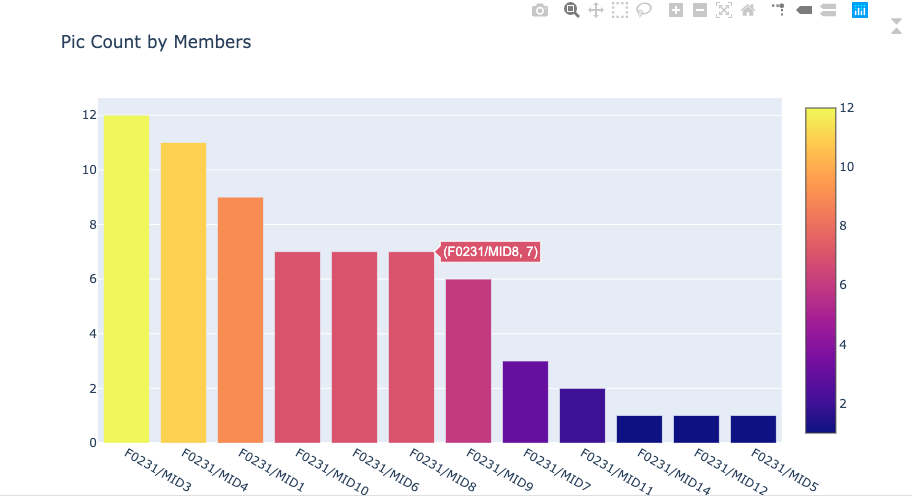

In [0]:
#https://stackoverflow.com/questions/10628262/inserting-image-into-ipython-notebook-markdown
from IPython.display import Image
Image(filename='/content/Screen Shot 2019-08-11 at 2.05.57 PM.png')

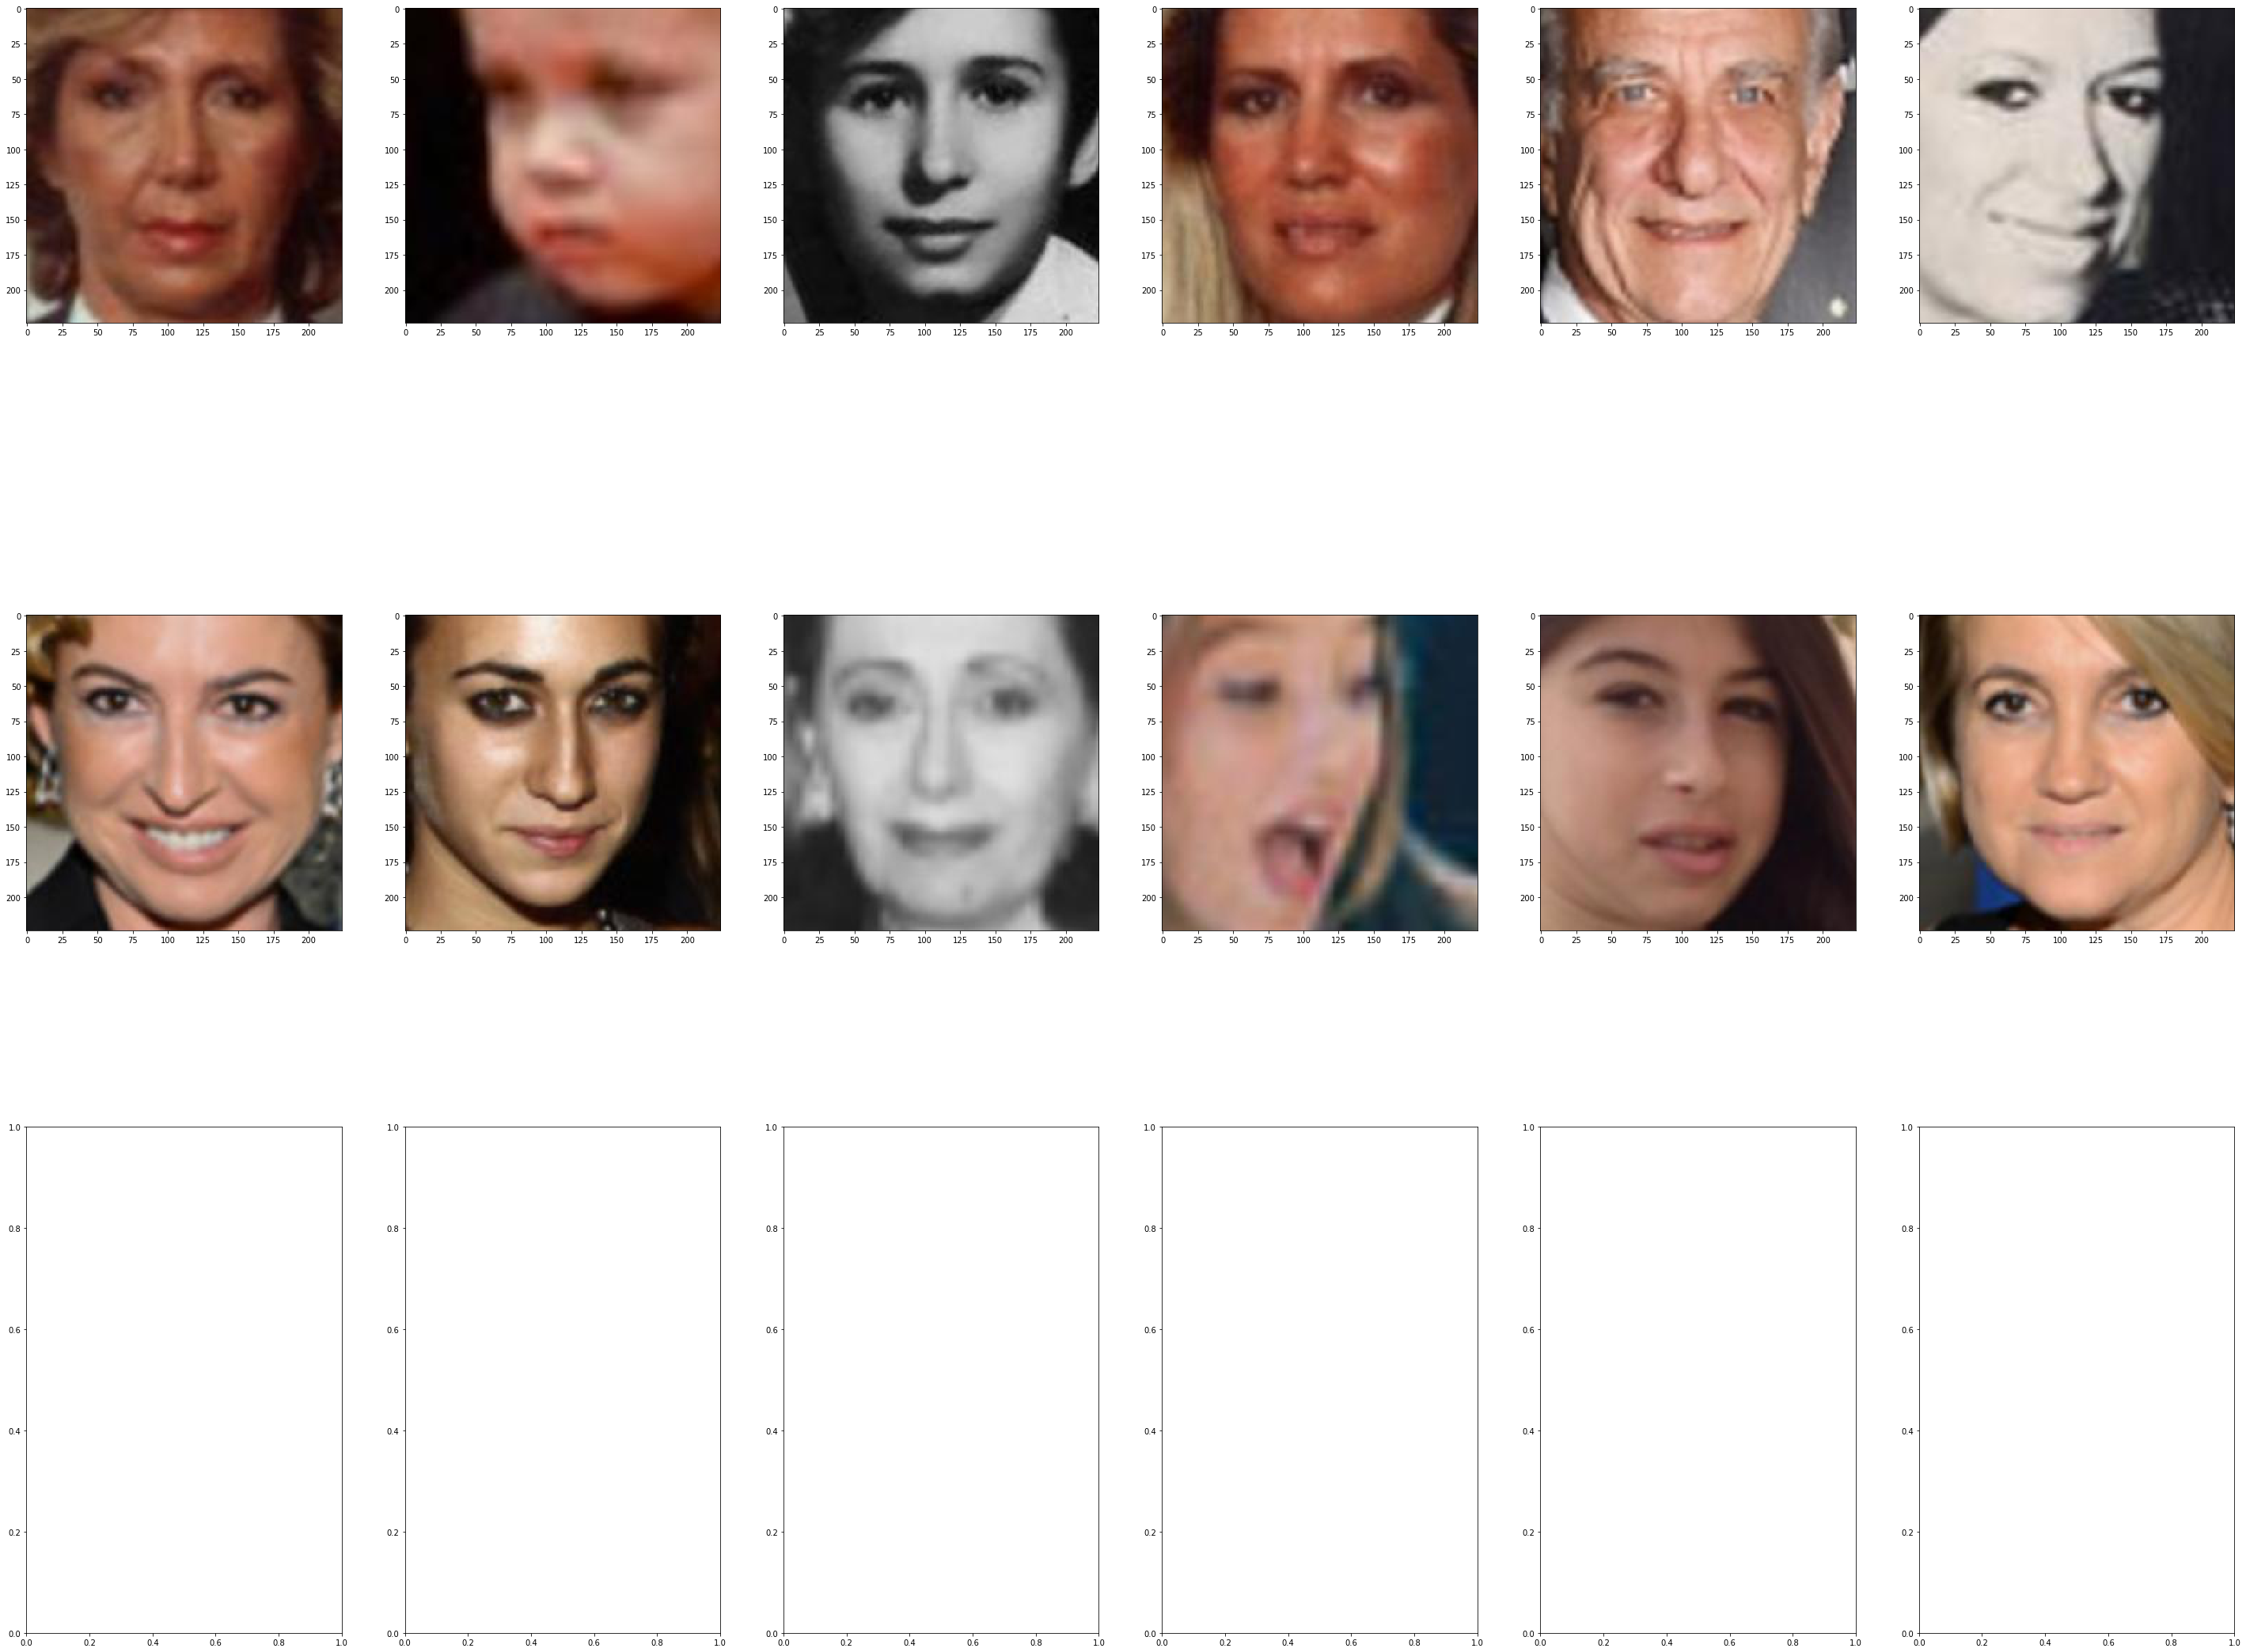

In [0]:
render_images(large_family_df)

**NOW MODELLING and TRAINING THE MODEL**

In [0]:
train_file_path = "../input/train_relationships.csv"
train_folders_path = "../input/train/"
val_famillies = "F09"

> splitting into train and validation image.

In [0]:
#train image takes all the files not in validation data.
train_images = [x for x in files if val_famillies not in x]
#validation image takes all the files in validation image.
val_images = [x for x in files if val_famillies in x]

**there are 11232 train and 1147 val images in list.**

In [0]:
len(train_images), len(val_images)

(11232, 1147)

In [0]:
train_images[0:2]

['../input/train/F0897/MID2/P09464_face1.jpg',
 '../input/train/F0897/MID5/P09469_face1.jpg']

> makes dictionary with family unique id as keys and image of person as values

In [0]:
#making a dict from default list.
train_person_to_images_map = defaultdict(list)
ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in files]

#below codes makes dictionary with family unique id as keys and image of person as values
for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

#similarly for validation also.
val_person_to_images_map = defaultdict(list)

for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

In [0]:
ppl[0:2]

['F0897/MID2', 'F0897/MID5']

In [0]:
train_person_to_images_map["F0897/MID2"]

['../input/train/F0897/MID2/P09464_face1.jpg']

1.  train_df : making a list p1.values and p2.values and zipping it. 

In [0]:
train_df = list(zip(train_df.p1.values, train_df.p2.values))

**total data = 3362** **bold text**

In [0]:
train_df = [x for x in train_df if x[0] in ppl and x[1] in ppl]
len(train_df)


3362

**total train data=3066 and validation = 3362-3066=296**

In [0]:
train = [x for x in train_df if val_famillies not in x[0]]
val = [x for x in train_df if val_famillies in x[0]]
len(train)

3066

**loading all the images from provided path and resizing it to size(197, 197) and then changing it to array **
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img\
https://www.programcreek.com/python/example/89223/keras.preprocessing.image.load_img\
and then finally passing the arrays to preprocess_input(it changes arrays to vgg format)\
https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras/47556342

In [0]:
def read_img(path):
    img = image.load_img(path, target_size=(197, 197))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

# Defining a generator 
**since we have less dataset.**
https://www.kaggle.com/shivamsarawagi/wildimagedetection-0-875

In [0]:
def gen(list_tuples, person_to_images_map, batch_size=16):
    #taking the unique id
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2) #https://www.geeksforgeeks.org/python-random-sample-function/
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            #https://www.geeksforgeeks.org/python-numbers-choice-function/
            p1 = choice(ppl) # returns random item.from choosen batch
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])
        
        #giving two inputs and one labels
        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        yield [X1, X2], labels

In [0]:
#defining the model.
def baseline_model():
    #taking input of shape(197, 197, 3)
    input_1 = Input(shape=(197, 197, 3))
    input_2 = Input(shape=(197, 197, 3))
    #input_3 = Input(shape=(197, 197, 3))

    #loading the vggface model with resnet50
    base_model = VGGFace(model='resnet50', include_top=False)
    
    #training the last 4 layer
    for x in base_model.layers[:-4]:
        x.trainable = True
    
    #passing input to basemodel
    x1 = base_model(input_1)
    x2 = base_model(input_2)
    
    #concatinating with last trainable model
    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])
    
    #subtracting input 1 and 2 and multiplying x3 to itself
    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])
    
    #multiplying and subtracting.
    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    
    #x5 = Multiply()([x4, x4])
    #x6 = Multiply()([x3, x4])
    
    x = Concatenate(axis=-1)([x3, x4])
    
    #making dense hidden layers
    x = Dense(100, activation="relu")(x)
    #x = BatchNormalization()(x)
    x = Dropout(0.01)(x)
    
    x = Dense(64, activation="relu")(x)
    #x = BatchNormalization()(x)
    x = Dropout(0.02)(x)
    
    out = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=[input_1, input_2], outputs=[out])

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

    model.summary()

    return model

In [0]:
#https://www.kaggle.com/shivamsarawagi/wildimagedetection-0-875
file_path = "vgg_face.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

model = baseline_model()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 2048)         0           vggface_resnet50[1][0]           
__________

**start training the model.**

In [0]:
model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True,
                    validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=70, verbose=1,
                    workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)


Epoch 1/70
200/200 [==============================] - 92s 459ms/step - loss: 1.9887 - acc: 0.5684 - val_loss: 1.8649 - val_acc: 0.5962

Epoch 00001: val_acc improved from -inf to 0.59625, saving model to vgg_face.h5
Epoch 2/70
200/200 [==============================] - 62s 308ms/step - loss: 1.0084 - acc: 0.6016 - val_loss: 1.1606 - val_acc: 0.6019

Epoch 00002: val_acc improved from 0.59625 to 0.60188, saving model to vgg_face.h5
Epoch 3/70
200/200 [==============================] - 61s 307ms/step - loss: 0.7557 - acc: 0.6328 - val_loss: 0.9491 - val_acc: 0.5975

Epoch 00003: val_acc did not improve from 0.60188
Epoch 4/70
200/200 [==============================] - 62s 309ms/step - loss: 0.6522 - acc: 0.6556 - val_loss: 0.8418 - val_acc: 0.6269

Epoch 00004: val_acc improved from 0.60188 to 0.62687, saving model to vgg_face.h5
Epoch 5/70
200/200 [==============================] - 62s 308ms/step - loss: 0.6266 - acc: 0.6628 - val_loss: 0.8094 - val_acc: 0.6525

Epoch 00005: val_acc imp

200/200 [==============================] - 59s 295ms/step - loss: 0.3186 - acc: 0.8566 - val_loss: 0.5617 - val_acc: 0.7525

Epoch 00043: val_acc did not improve from 0.79500
Epoch 44/70
200/200 [==============================] - 60s 299ms/step - loss: 0.3113 - acc: 0.8709 - val_loss: 0.5276 - val_acc: 0.7644

Epoch 00044: val_acc did not improve from 0.79500
Epoch 45/70
200/200 [==============================] - 59s 296ms/step - loss: 0.3027 - acc: 0.8669 - val_loss: 0.5164 - val_acc: 0.7681

Epoch 00045: val_acc did not improve from 0.79500
Epoch 46/70
200/200 [==============================] - 59s 295ms/step - loss: 0.2892 - acc: 0.8750 - val_loss: 0.5279 - val_acc: 0.7681

Epoch 00046: val_acc did not improve from 0.79500
Epoch 47/70
200/200 [==============================] - 59s 294ms/step - loss: 0.2985 - acc: 0.8700 - val_loss: 0.5622 - val_acc: 0.7700

Epoch 00047: val_acc did not improve from 0.79500
Epoch 48/70
200/200 [==============================] - 59s 294ms/step - loss:

# Stacking
**credit** https://www.kaggle.com/vaishvik25/blend-of-smiles\
**Submission4 is taken from above link**

In [0]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output


In [0]:
sub1 = pd.read_csv('/content/stack_mean.csv')
sub2 = pd.read_csv('/content/submission4.csv')

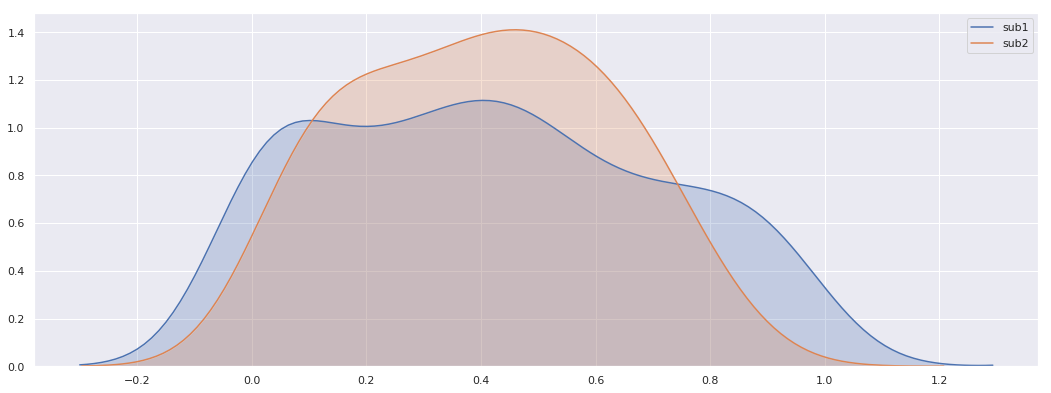

In [0]:
sns.set(rc={'figure.figsize':(18,6.5)})
sns.kdeplot(sub1['is_related'],label="sub1",shade=True,bw=.1)
sns.kdeplot(sub2['is_related'], label="sub2",shade=True,bw=.1)

In [0]:
temp=pd.read_csv('stack_mean.csv')

In [0]:
temp['is_related'] = 0.5*sub1['is_related'] + 0.5*sub2['is_related'] 
temp.to_csv('submission5.csv', index=False )

In [0]:
#https://www.kaggle.com/vaishvik25/blend-of-smiles

# Conclusion
**On test data this model performed better than val_data and tweaking output a little bit and with lots of output, model performed much better**\
**training last 4 layers gives good results than 3 in val data. but when it comes to test 3 performs better**\
**stacking results in rank under 20.**

# Steps Done:
1. Importing necessary libraries.
2. Rcmallai vggnet
4. loading csv
5. Creating dataframe.
6. putting all images in file
7. Visualizing the person with most pic
8. Checking families with most member and least member.
9. Visualiging yop and 5th family.
10. seperating images into train and test.
11. Defining a generator.
12. defining a baseline model with vggnet.
13. start training model